# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Write the problem in your own words here

In [4]:
#!/usr/bin/python3

#your info here
__author__ = 'Johnson Aremu'
__email__ = "jaremu@gmail.com / johnsonaremu@gmail.com"

#This python project reads Salary data and makes predictions on Salary records using models learnt 
# in  Data Science predictive modeling linear regression.

#import your libraries
!pip install pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


Defaulting to user installation because normal site-packages is not writeable


## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [6]:
#load the data into a Pandas dataframe

def load_file(file):
    '''loads csv to pd dataframe'''
    return pd.read_csv(file)

def consolidate_data(df1, df2, key=None, left_index=False, right_index=False):
    '''perform inner join to return only records that are present in both dataframes'''
    return pd.merge(left=df1, right=df2, how='inner', on=key, left_index=left_index, right_index=right_index)

### ---- 3 Clean the data ----

In [7]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it

def clean_data(raw_df):
    '''remove rows that contain salary <= 0 or duplicate job IDs'''
    clean_df = raw_df.drop_duplicates(subset='jobId')
    clean_df = clean_df[clean_df.salary>0]
    return clean_df

### ---- 4 Explore the data (EDA) ----

In [8]:
#summarize each feature variable
#look for correlation between each feature and the target
#look for correlation between features

def one_hot_encode_feature_df(df, cat_vars=None, num_vars=None):
    '''performs one-hot encoding on all categorical variables and combines result with continous variables'''
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)#,ignore_index=False)

#summarize the target variable

def get_target_df(df, target):
    '''returns target dataframe'''
    return df[target]

### ---- 5 Establish a baseline ----

In [9]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation
def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=2, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [10]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model
def save_results(model, mean_mse, predictions, feature_importances):
    '''saves model, model summary, feature importances, and predictions'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions.csv', predictions, delimiter=',')


### ---- 8 Create models ----

In [12]:
#create and tune the models that you brainstormed during part 2
if __name__ == '__main__':
    #define inputs
    train_feature_file = 'data/train_features.csv'
    train_target_file = 'data/train_salaries.csv'
    test_feature_file = 'data/test_features.csv'

    #define variables
    categorical_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
    numeric_vars = ['yearsExperience', 'milesFromMetropolis']
    target_var = 'salary'

    #load data
    print("Loading data")
    feature_df = load_file(train_feature_file)
    target_df = load_file(train_target_file)
    test_df = load_file(test_feature_file)

    #consolidate training data
    raw_train_df = consolidate_data(feature_df, target_df, key='jobId')

    #clean, shuffle, and reindex training data -- shuffling may improve cross-validation accuracy
    clean_train_df = shuffle(clean_data(raw_train_df)).reset_index()

    #encode categorical data and get final feature dfs
    print("Encoding data")
    feature_df = one_hot_encode_feature_df(clean_train_df, cat_vars=categorical_vars, num_vars=numeric_vars)
    test_df = one_hot_encode_feature_df(test_df, cat_vars=categorical_vars, num_vars=numeric_vars)

    #get target df
    target_df = get_target_df(clean_train_df, target_var)

    #initialize model list and dicts
    models = []
    mean_mse = {}
    cv_std = {}
    res = {}

    #define number of processes to run in parallel
    num_procs = 2

    #shared model paramaters
    verbose_lvl = 5

    #create models -- hyperparameter tuning already done by hand for each model
    lr = LinearRegression()
    lr_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
    rf = RandomForestRegressor(n_estimators=60, n_jobs=num_procs, max_depth=25, min_samples_split=60, \
                               max_features=30, verbose=verbose_lvl)
    gbm = GradientBoostingRegressor(n_estimators=40, max_depth=5, loss='ls', verbose=verbose_lvl)

    models.extend([lr, lr_std_pca, rf, gbm])

    #parallel cross-validate models, using MSE as evaluation metric, and print summaries
    print("Beginning cross validation")
    for model in models:
        train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std)
        print_summary(model, mean_mse, cv_std)

    #choose model with lowest mse
    model = min(mean_mse, key=mean_mse.get)
    print('\nPredictions calculated using model with lowest MSE:')
    print(model)

    #train model on entire dataset
    model.fit(feature_df, target_df)

    #create predictions based on test data
    predictions = model.predict(test_df)

    #store feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        #linear models don't have feature_importances_
        importances = [0]*len(feature_df.columns)

    feature_importances = pd.DataFrame({'feature':feature_df.columns, 'importance':importances})
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    
    #set index to 'feature'
    feature_importances.set_index('feature', inplace=True, drop=True)
    
    #create plot
    #feature_importances[0:25].plot.bar(figsize=(20,10))
    #plt.show()

    #save results
    save_results(model, mean_mse[model], predictions, feature_importances)

Loading data
Encoding data
Beginning cross validation

Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average MSE:
 384.4618534449795
Standard deviation during CV:
 0.6240163209646141

Model:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Average MSE:
 384.4564142954343
Standard deviation during CV:
 0.6114214044828827

Model:
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features=30, max_leaf_nodes=None,


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 60building tree 2 of 60

building tree 3 of 60
building tree 4 of 60
building tree 5 of 60
building tree 6 of 60
building tree 7 of 60
building tree 8 of 60
building tree 9 of 60
building tree 10 of 60
building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.2min


building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60
building tree 21 of 60
building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 60
building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60
building tr

[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:  5.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   14.8s finished


### ---- 9 Test models ----

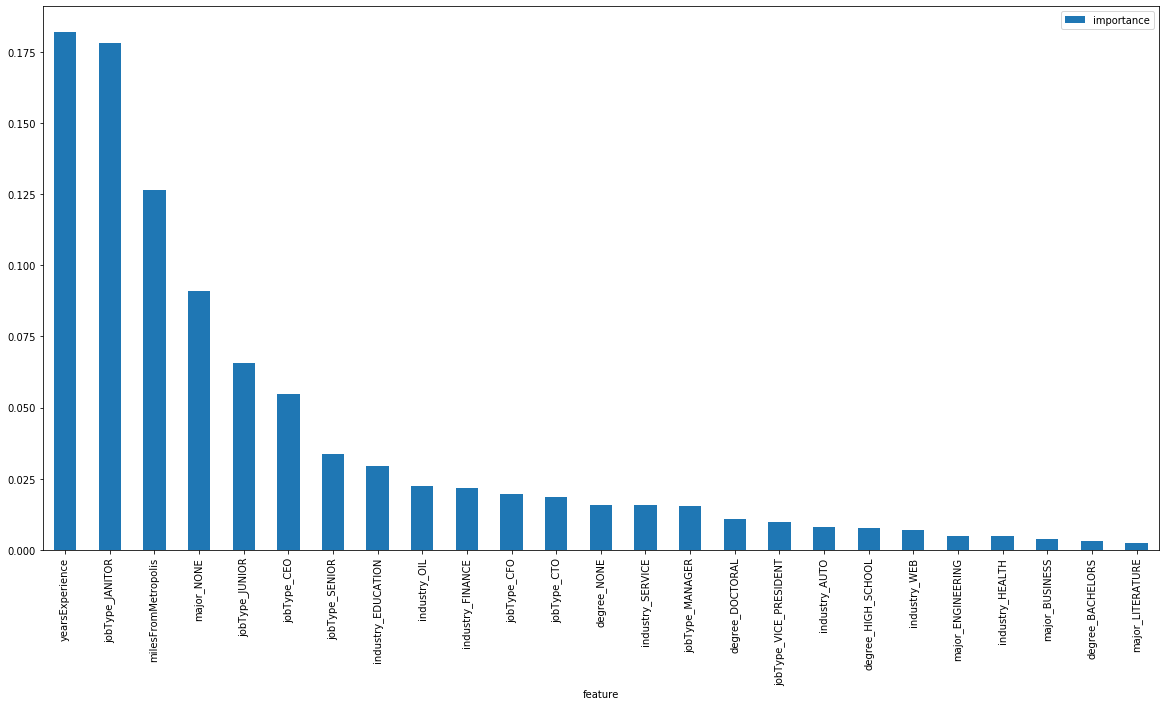

In [13]:
#do 5-fold cross validation on models and measure MSE
feature_importances[0:25].plot.bar(figsize=(20,10))
plt.show()

### ---- 10 Select best model  ----

In [14]:
#select the model with the lowest error as your "prodcuction" model
!cat model.txt

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=60, min_weight_fraction_leaf=0.0,
                      n_estimators=60, n_jobs=2, oob_score=False,
                      random_state=None, verbose=5, warm_start=False)

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [15]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders
!head feature_importances.csv
!head predictions.csv

feature,importance
yearsExperience,0.1818992010125919
jobType_JANITOR,0.1781265218544207
milesFromMetropolis,0.12655169040338834
major_NONE,0.09102302957892408
jobType_JUNIOR,0.06562493274868736
jobType_CEO,0.054625839626755296
jobType_SENIOR,0.0335608572290807
industry_EDUCATION,0.02942714729840246
industry_OIL,0.022370702260150803
1.135278968249869251e+02
9.507333200620291791e+01
1.772848666112496971e+02
1.050676959803903543e+02
1.120168474612235769e+02
1.526155478976748157e+02
9.718759335153959000e+01
1.209081901787831725e+02
1.078495000787040965e+02
9.931195782551526463e+01


### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data